In [ ]:
! pip install pennylane opacus torchattacks

In [1]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from transformers import ViTForImageClassification, ViTModel
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
import numpy as np
import random
import matplotlib.pyplot as plt
import torchattacks
from tqdm import tqdm
from scipy import stats

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Define quantum device and circuit
n_qubits = 8  # Choose based on your computational resources
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Embed data into the quantum circuit
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))

    # Apply parameterized quantum gates
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    # Return expectation values
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# Define a PyTorch layer that uses the quantum circuit
class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers=2):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        # Quantum circuits typically require values in [-π,π]
        x = torch.tanh(x) * np.pi
        return self.qlayer(x)

# Hybrid Quantum-Classical model that combines ViT features with quantum processing
class QuantumViT(nn.Module):
    def __init__(self, vit_model_name, n_qubits, num_classes=10):
        super().__init__()
        # Load pre-trained ViT model (use the backbone only)
        self.vit = ViTModel.from_pretrained(vit_model_name)

        # Freeze ViT weights for transfer learning
        for param in self.vit.parameters():
            param.requires_grad = False

        # Get ViT hidden size
        hidden_size = self.vit.config.hidden_size  # Typically 768

        # Projection layer to reduce dimensionality
        self.projection = nn.Linear(hidden_size, n_qubits)

        # Quantum layer
        self.quantum_layer = QuantumLayer(n_qubits)

        # Classification head
        self.classifier = nn.Linear(n_qubits, num_classes)

    def forward(self, x):
        # Extract features using ViT (get [CLS] token)
        outputs = self.vit(x)
        cls_token = outputs.last_hidden_state[:, 0, :]

        # Project to quantum dimension
        quantum_input = self.projection(cls_token)

        # Apply quantum processing
        quantum_output = self.quantum_layer(quantum_input)

        # Classification
        logits = self.classifier(quantum_output)
        return logits

# Define device, hyperparameters, and data loading
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
batch_size = 32
epochs = 10  # Adjust as needed
learning_rate = 0.01
noise_multiplier = 0.005  # For differential privacy
max_grad_norm = 2.0

# Data transforms and loaders
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Use a subset for faster training
num_samples = 1000
train_dataset = Subset(train_dataset, range(num_samples))
test_dataset = Subset(test_dataset, range(num_samples))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the model name
model_name = "google/vit-base-patch16-224-in21k"

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = F.cross_entropy(outputs, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}")
    avg_epoch_loss = epoch_loss / len(train_loader)
    return avg_epoch_loss

def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            test_loss += F.cross_entropy(outputs, target, reduction='sum').item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.size(0)
    test_loss /= total
    accuracy = correct / total
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({accuracy * 100:.2f}%)")
    return accuracy, test_loss

def evaluate_model_robustness(model, test_loader, device, epsilon=1):
    """Helper function to evaluate model robustness."""
    model.eval()

    # Clean accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    clean_accuracy = 100 * correct / total

    # FGSM attack
    fgsm_attack = torchattacks.FGSM(model, eps=epsilon)
    fgsm_correct = 0

    # PGD attack
    pgd_attack = torchattacks.PGD(model, eps=epsilon, alpha=epsilon/10, steps=20)
    pgd_correct = 0

    for inputs, labels in tqdm(test_loader, desc="Testing adversarial robustness"):
        inputs, labels = inputs.to(device), labels.to(device)

        # FGSM attack
        fgsm_images = fgsm_attack(inputs, labels)
        with torch.no_grad():
            outputs = model(fgsm_images)
        _, predicted = torch.max(outputs.data, 1)
        fgsm_correct += (predicted == labels).sum().item()

        # PGD attack
        pgd_images = pgd_attack(inputs, labels)
        with torch.no_grad():
            outputs = model(pgd_images)
        _, predicted = torch.max(outputs.data, 1)
        pgd_correct += (predicted == labels).sum().item()

    fgsm_accuracy = 100 * fgsm_correct / total
    pgd_accuracy = 100 * pgd_correct / total

    print(f"Clean Accuracy: {clean_accuracy:.2f}%")
    print(f"FGSM Accuracy: {fgsm_accuracy:.2f}%")
    print(f"PGD Accuracy: {pgd_accuracy:.2f}%")

    return clean_accuracy, fgsm_accuracy, pgd_accuracy

def epsilon_sensitivity_analysis(model, test_loader, device, epsilons=[0.001, 0.05, 1, 5]):
    """Run both FGSM and PGD attacks with varying epsilon values."""
    fgsm_accuracies = []
    pgd_accuracies = []
    clean_accuracy = 0
    total = 0

    # Calculate clean accuracy first
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            clean_accuracy += (predicted == labels).sum().item()

    clean_accuracy = 100 * clean_accuracy / total
    print(f"Clean accuracy: {clean_accuracy:.2f}%")

    # Test with different epsilon values
    for eps in epsilons:
        # FGSM Attack
        fgsm_attack = torchattacks.FGSM(model, eps=eps)
        pgd_attack = torchattacks.PGD(model, eps=eps, alpha=eps/20, steps=10)

        fgsm_correct = 0
        pgd_correct = 0
        total = 0

        for images, labels in tqdm(test_loader, desc=f"Testing ε={eps}"):
            images, labels = images.to(device), labels.to(device)

            # FGSM attack
            fgsm_images = fgsm_attack(images, labels)
            outputs = model(fgsm_images)
            _, predicted = torch.max(outputs.data, 1)
            fgsm_correct += (predicted == labels).sum().item()

            # PGD attack
            pgd_images = pgd_attack(images, labels)
            outputs = model(pgd_images)
            _, predicted = torch.max(outputs.data, 1)
            pgd_correct += (predicted == labels).sum().item()

            total += labels.size(0)

        fgsm_accuracy = 100 * fgsm_correct / total
        pgd_accuracy = 100 * pgd_correct / total

        fgsm_accuracies.append(fgsm_accuracy)
        pgd_accuracies.append(pgd_accuracy)

        print(f"Epsilon: {eps}, FGSM Accuracy: {fgsm_accuracy:.2f}%, PGD Accuracy: {pgd_accuracy:.2f}%")

    # Plot results with improved visualization
    plt.figure(figsize=(12, 7))
    plt.plot(epsilons, fgsm_accuracies, 'o-', label='FGSM Attack', linewidth=2)
    plt.plot(epsilons, pgd_accuracies, 's-', label='PGD Attack', linewidth=2)
    plt.axhline(y=clean_accuracy, color='g', linestyle='--', label='Clean Accuracy', linewidth=2)
    plt.xlabel('Perturbation Magnitude (ε)', fontsize=12)
    plt.ylabel('Robust Accuracy (%)', fontsize=12)
    plt.title('Robustness Against Adversarial Attacks', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('epsilon_sensitivity_analysis.png', dpi=300)
    plt.show()

    return clean_accuracy, fgsm_accuracies, pgd_accuracies

def privacy_budget_experiment(model_class, train_loader, test_loader, device,
                             noise_multipliers=[0.5, 1.0, 2.0, 5.0],
                             epsilon=1,  # Fixed epsilon for attacks
                             epochs=5):
    """Test models with different privacy budgets to show how privacy affects robustness."""
    results = []

    # First, train a baseline model without DP
    print("\nTraining baseline model without DP")
    baseline_model = model_class().to(device)
    optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    # Train baseline model
    for epoch in range(epochs):
        baseline_model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = baseline_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

    # Evaluate baseline model
    baseline_clean_acc, baseline_fgsm_acc, baseline_pgd_acc = evaluate_model_robustness(
        baseline_model, test_loader, device, epsilon)

    results.append({
        'model_type': 'Baseline (Non-DP)',
        'noise_multiplier': 0,
        'epsilon': float('inf'),
        'clean_accuracy': baseline_clean_acc,
        'fgsm_accuracy': baseline_fgsm_acc,
        'pgd_accuracy': baseline_pgd_acc
    })

    # Now train models with different privacy budgets
    for noise_multiplier in noise_multipliers:
        print(f"\nTraining with noise_multiplier={noise_multiplier}")

        # Initialize a new model for each privacy setting
        model = model_class().to(device)
        if not ModuleValidator.is_valid(model):
            model = ModuleValidator.fix(model)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Setup privacy engine
        privacy_engine = PrivacyEngine()
        model, optimizer, private_train_loader = privacy_engine.make_private_with_epsilon(
            module=model,
            optimizer=optimizer,
            data_loader=train_loader,
            epochs=epochs,
            target_epsilon=5.0,  # Target privacy budget
            target_delta=1e-5,
            max_grad_norm=1.0,
        )

        # Train the model
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in tqdm(private_train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print(f"Epoch {epoch+1}, Loss: {running_loss/len(private_train_loader):.4f}")

        # Get the actual privacy budget
        actual_epsilon = privacy_engine.get_epsilon(delta=1e-5)

        model.disable_hooks()  # Disable DP hooks for evaluation

        # Evaluate model robustness
        clean_acc, fgsm_acc, pgd_acc = evaluate_model_robustness(
            model, test_loader, device, epsilon)

        results.append({
            'model_type': f'DP (ε = {actual_epsilon:.1f})',
            'noise_multiplier': noise_multiplier,
            'epsilon': actual_epsilon,
            'clean_accuracy': clean_acc,
            'fgsm_accuracy': fgsm_acc,
            'pgd_accuracy': pgd_acc
        })

    # Create bar chart comparing results
    model_types = [r['model_type'] for r in results]
    clean_accs = [r['clean_accuracy'] for r in results]
    fgsm_accs = [r['fgsm_accuracy'] for r in results]
    pgd_accs = [r['pgd_accuracy'] for r in results]

    x = np.arange(len(model_types))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.bar(x - width, clean_accs, width, label='Clean Accuracy')
    ax.bar(x, fgsm_accs, width, label='FGSM Attack')
    ax.bar(x + width, pgd_accs, width, label='PGD Attack')

    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Impact of Differential Privacy on Model Robustness', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(model_types, rotation=45, ha='right')
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('privacy_robustness_tradeoff.png', dpi=300)
    plt.show()

    return results


def quantum_classical_comparison(quantum_model, classical_model, test_loader, device, epsilons=[0.5, 1.0, 2.0, 5.0]):
    """Compare quantum and classical models across different attack strengths."""
    results = {'Quantum': {}, 'Classical': {}}

    for model_name, model in [('Quantum', quantum_model), ('Classical', classical_model)]:
        print(f"\nEvaluating {model_name} model")

        # Clean accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        clean_accuracy = 100 * correct / total
        results[model_name]['clean'] = clean_accuracy
        print(f"{model_name} Clean Accuracy: {clean_accuracy:.2f}%")

        # Test with different attack strengths
        for eps in epsilons:
            fgsm_attack = torchattacks.FGSM(model, eps=eps)
            pgd_attack = torchattacks.PGD(model, eps=eps, alpha=eps/4, steps=10)

            fgsm_correct = 0
            pgd_correct = 0

            for inputs, labels in tqdm(test_loader, desc=f"Testing ε={eps}"):
                inputs, labels = inputs.to(device), labels.to(device)

                # FGSM attack
                fgsm_images = fgsm_attack(inputs, labels)
                with torch.no_grad():
                    outputs = model(fgsm_images)
                _, predicted = torch.max(outputs.data, 1)
                fgsm_correct += (predicted == labels).sum().item()

                # PGD attack
                pgd_images = pgd_attack(inputs, labels)
                with torch.no_grad():
                    outputs = model(pgd_images)
                _, predicted = torch.max(outputs.data, 1)
                pgd_correct += (predicted == labels).sum().item()

            fgsm_accuracy = 100 * fgsm_correct / total
            pgd_accuracy = 100 * pgd_correct / total

            results[model_name][f'fgsm_{eps}'] = fgsm_accuracy
            results[model_name][f'pgd_{eps}'] = pgd_accuracy

            print(f"{model_name} FGSM (ε={eps}) Accuracy: {fgsm_accuracy:.2f}%")
            print(f"{model_name} PGD (ε={eps}) Accuracy: {pgd_accuracy:.2f}%")

    # Create visualization
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    # FGSM comparison
    axs[0].plot(epsilons, [results['Quantum'][f'fgsm_{eps}'] for eps in epsilons], 'o-',
                label='Quantum Model', linewidth=2)
    axs[0].plot(epsilons, [results['Classical'][f'fgsm_{eps}'] for eps in epsilons], 's-',
                label='Classical Model', linewidth=2)
    axs[0].set_xlabel('Perturbation Magnitude (ε)', fontsize=12)
    axs[0].set_ylabel('Robust Accuracy (%)', fontsize=12)
    axs[0].set_title('Robustness Against FGSM Attack', fontsize=14)
    axs[0].legend(fontsize=12)
    axs[0].grid(True)

    # PGD comparison
    axs[1].plot(epsilons, [results['Quantum'][f'pgd_{eps}'] for eps in epsilons], 'o-',
                label='Quantum Model', linewidth=2)
    axs[1].plot(epsilons, [results['Classical'][f'pgd_{eps}'] for eps in epsilons], 's-',
                label='Classical Model', linewidth=2)
    axs[1].set_xlabel('Perturbation Magnitude (ε)', fontsize=12)
    axs[1].set_ylabel('Robust Accuracy (%)', fontsize=12)
    axs[1].set_title('Robustness Against PGD Attack', fontsize=14)
    axs[1].legend(fontsize=12)
    axs[1].grid(True)

    plt.tight_layout()
    plt.savefig('quantum_classical_comparison.png', dpi=300)
    plt.show()

    return results


def mixed_adversarial_training(model, train_loader, test_loader, device,
                              epsilon=1, alpha=0.01, steps=10,
                               epochs=10, mix_ratio=0.5):
    """Train model with a mix of clean and adversarial examples."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # For tracking progress
    train_losses = []
    clean_accuracies = []
    fgsm_accuracies = []
    pgd_accuracies = []

    # Initial evaluation
    clean_acc, fgsm_acc, pgd_acc = evaluate_model_robustness(model, test_loader, device, epsilon)
    clean_accuracies.append(clean_acc)
    fgsm_accuracies.append(fgsm_acc)
    pgd_accuracies.append(pgd_acc)

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Generate adversarial examples (PGD attack)
            if random.random() < mix_ratio:
                pgd_attack = torchattacks.PGD(model, eps=epsilon, alpha=alpha, steps=steps)
                adv_inputs = pgd_attack(inputs, labels)

                # Mix clean and adversarial examples
                mixed_inputs = torch.cat([inputs, adv_inputs], dim=0)
                mixed_labels = torch.cat([labels, labels], dim=0)

                # Forward pass
                optimizer.zero_grad()
                outputs = model(mixed_inputs)
                loss = criterion(outputs, mixed_labels)
            else:
                # Regular training with clean examples
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluate model after each epoch
        clean_acc, fgsm_acc, pgd_acc = evaluate_model_robustness(model, test_loader, device, epsilon)
        clean_accuracies.append(clean_acc)
        fgsm_accuracies.append(fgsm_acc)
        pgd_accuracies.append(pgd_acc)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        print(f"Clean Acc: {clean_acc:.2f}%, FGSM Acc: {fgsm_acc:.2f}%, PGD Acc: {pgd_acc:.2f}%")

    # Plot training progress
    plt.figure(figsize=(15, 5))

    # Plot 1: Training loss
    plt.subplot(1, 3, 1)
    plt.plot(range(epochs), train_losses, 'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Over Time')
    plt.grid(True)

    # Plot 2: Clean accuracy
    plt.subplot(1, 3, 2)
    plt.plot(range(epochs+1), clean_accuracies, 'o-', label='Clean')
    plt.plot(range(epochs+1), fgsm_accuracies, 's-', label='FGSM')
    plt.plot(range(epochs+1), pgd_accuracies, '^-', label='PGD')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 3: Robustness improvement
    plt.subplot(1, 3, 3)
    plt.bar(['Initial', 'Final'], [pgd_accuracies[0], pgd_accuracies[-1]], color=['blue', 'green'])
    plt.ylabel('PGD Robustness (%)')
    plt.title('Robustness Improvement')
    plt.grid(True, axis='y')

    plt.tight_layout()
    plt.savefig('mixed_adversarial_training.png', dpi=300)
    plt.show()

    return model, clean_accuracies, fgsm_accuracies, pgd_accuracies




def dp_adversarial_training(model, train_loader, test_loader, device,
                           noise_multiplier=0.1, max_grad_norm=2.0,
                           epsilon=1, alpha=0.01, steps=3,
                           epochs=10, mix_ratio=0.5):
    """Train model with both differential privacy and adversarial examples."""
    # Setup model for differential privacy
    if not ModuleValidator.is_valid(model):
        model = ModuleValidator.fix(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    # Setup privacy engine
    privacy_engine = PrivacyEngine()
    model, optimizer, private_train_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=max_grad_norm
    )

    # For tracking progress
    train_losses = []
    clean_accuracies = []
    fgsm_accuracies = []
    pgd_accuracies = []

    # Initial evaluation
    model.disable_hooks()  # Temporarily disable DP hooks for evaluation
    clean_acc, fgsm_acc, pgd_acc = evaluate_model_robustness(model, test_loader, device, epsilon)
    model.enable_hooks()   # Re-enable DP hooks

    clean_accuracies.append(clean_acc)
    fgsm_accuracies.append(fgsm_acc)
    pgd_accuracies.append(pgd_acc)

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(private_train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Generate adversarial examples (PGD attack)
            if random.random() < mix_ratio:
                # Temporarily disable DP hooks for generating adversarial examples
                model.disable_hooks()
                pgd_attack = torchattacks.PGD(model, eps=epsilon, alpha=alpha, steps=steps)
                adv_inputs = pgd_attack(inputs, labels)
                model.enable_hooks()

                # Train on adversarial examples with DP
                optimizer.zero_grad()
                outputs = model(adv_inputs)
                loss = criterion(outputs, labels)
            else:
                # Regular training with DP
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Backward pass and optimization (with DP)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(private_train_loader)
        train_losses.append(avg_loss)

        # Evaluate model after each epoch
        model.disable_hooks()  # Disable DP hooks for evaluation
        clean_acc, fgsm_acc, pgd_acc = evaluate_model_robustness(model, test_loader, device, epsilon)
        model.enable_hooks()   # Re-enable DP hooks

        clean_accuracies.append(clean_acc)
        fgsm_accuracies.append(fgsm_acc)
        pgd_accuracies.append(pgd_acc)

        # Get current privacy budget
        epsilon_spent = privacy_engine.get_epsilon(delta=1e-5)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Privacy Budget (ε): {epsilon_spent:.2f}")
        print(f"Clean Acc: {clean_acc:.2f}%, FGSM Acc: {fgsm_acc:.2f}%, PGD Acc: {pgd_acc:.2f}%")

    # Final privacy budget
    final_epsilon = privacy_engine.get_epsilon(delta=1e-5)
    print(f"Final Privacy Budget (ε): {final_epsilon:.2f}")

    # Plot training progress
    plt.figure(figsize=(15, 5))

    # Plot 1: Training loss
    plt.subplot(1, 3, 1)
    plt.plot(range(epochs), train_losses, 'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Over Time')
    plt.grid(True)

    # Plot 2: Accuracy metrics
    plt.subplot(1, 3, 2)
    plt.plot(range(epochs+1), clean_accuracies, 'o-', label='Clean')
    plt.plot(range(epochs+1), fgsm_accuracies, 's-', label='FGSM')
    plt.plot(range(epochs+1), pgd_accuracies, '^-', label='PGD')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Model Accuracy (ε={final_epsilon:.2f})')
    plt.legend()
    plt.grid(True)

    # Plot 3: Robustness comparison
    plt.subplot(1, 3, 3)
    x = np.arange(2)
    width = 0.35
    plt.bar(x - width/2, [clean_accuracies[0], clean_accuracies[-1]], width, label='Clean')
    plt.bar(x + width/2, [pgd_accuracies[0], pgd_accuracies[-1]], width, label='PGD')
    plt.xticks(x, ['Initial', 'Final'])
    plt.ylabel('Accuracy (%)')
    plt.title('Robustness Improvement')
    plt.legend()
    plt.grid(True, axis='y')

    plt.tight_layout()
    plt.savefig('dp_adversarial_training.png', dpi=300)
    plt.show()

    return model, final_epsilon, clean_accuracies, fgsm_accuracies, pgd_accuracies


def comparative_analysis(results_dict, epsilon=1):
    """Compare all methods in terms of robustness and privacy."""
    # Extract data from results
    models = list(results_dict.keys())
    clean_accs = [results_dict[model]['clean_accuracy'] for model in models]
    fgsm_accs = [results_dict[model]['fgsm_accuracy'] for model in models]
    pgd_accs = [results_dict[model]['pgd_accuracy'] for model in models]

    # Privacy budgets (if applicable, otherwise inf)
    privacy_budgets = [results_dict[model].get('privacy_budget', float('inf')) for model in models]

    # Create bar chart for accuracy metrics
    plt.figure(figsize=(14, 8))

    x = np.arange(len(models))
    width = 0.25

    plt.bar(x - width, clean_accs, width, label='Clean Accuracy')
    plt.bar(x, fgsm_accs, width, label='FGSM Attack')
    plt.bar(x + width, pgd_accs, width, label='PGD Attack')

    plt.xlabel('Model Type')
    plt.ylabel('Accuracy (%)')
    plt.title('Robustness Against Adversarial Attacks')
    plt.xticks(x, models, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Add privacy budget annotations
    for i, budget in enumerate(privacy_budgets):
        if budget < float('inf'):
            plt.annotate(f'ε={budget:.1f}',
                        xy=(i, clean_accs[i] + 2),
                        ha='center',
                        fontsize=9,
                        bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3))

    plt.tight_layout()
    plt.savefig('comparative_analysis.png', dpi=300)
    plt.show()

    # Create a table with all metrics
    print("\nComparative Analysis of All Methods:")
    print(f"{'Model':<25} {'Clean Acc':<12} {'FGSM Acc':<12} {'PGD Acc':<12} {'Privacy Budget':<15}")
    print("-" * 75)

    for i, model in enumerate(models):
        privacy_str = f"ε={privacy_budgets[i]:.2f}" if privacy_budgets[i] < float('inf') else "No DP"
        print(f"{model:<25} {clean_accs[i]:<12.2f} {fgsm_accs[i]:<12.2f} {pgd_accs[i]:<12.2f} {privacy_str:<15}")

    return {
        'models': models,
        'clean_accuracies': clean_accs,
        'fgsm_accuracies': fgsm_accs,
        'pgd_accuracies': pgd_accs,
        'privacy_budgets': privacy_budgets
    }



Using device: cuda


100%|██████████| 170M/170M [00:05<00:00, 29.9MB/s]


Clean accuracy: 9.60%


Testing ε=0.5: 100%|██████████| 32/32 [02:19<00:00,  4.37s/it]


Epsilon: 0.5, FGSM Accuracy: 7.50%, PGD Accuracy: 0.10%


Testing ε=5.0: 100%|██████████| 32/32 [02:21<00:00,  4.42s/it]


Epsilon: 5.0, FGSM Accuracy: 8.90%, PGD Accuracy: 1.20%


Testing ε=10.0: 100%|██████████| 32/32 [02:21<00:00,  4.42s/it]


Epsilon: 10.0, FGSM Accuracy: 8.90%, PGD Accuracy: 5.80%


Testing ε=50.0: 100%|██████████| 32/32 [02:21<00:00,  4.42s/it]


Epsilon: 50.0, FGSM Accuracy: 8.90%, PGD Accuracy: 8.90%


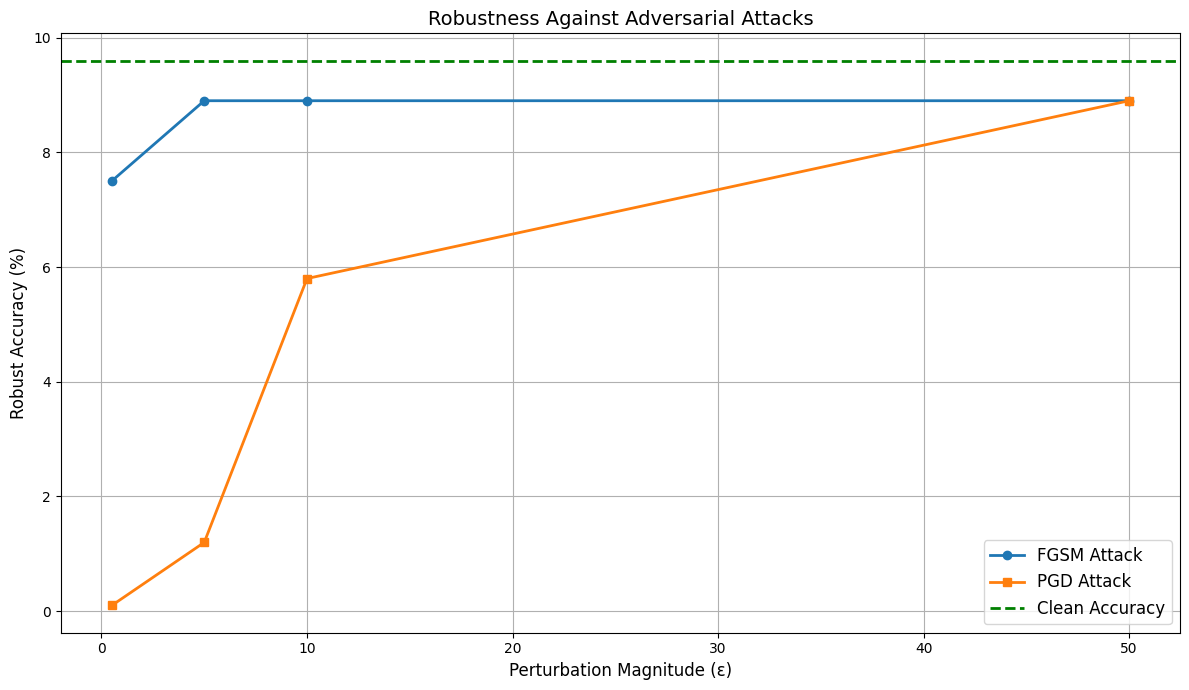

In [3]:
# Initialize quantum-enhanced model
model_quantum = QuantumViT(model_name, n_qubits=8, num_classes=10)
model_quantum.to(device)


# Run epsilon sensitivity analysis on your trained model
clean_acc, fgsm_accs, pgd_accs = epsilon_sensitivity_analysis(
    model=model_quantum,  # Your trained quantum model
    test_loader=test_loader,
    device=device,
    epsilons=[0.5, 5.0, 10.0, 50.0] # rerun
)

# This will output a plot showing how model robustness changes with different perturbation magnitudes



Training baseline model without DP


Epoch 1/5: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


Epoch 1, Loss: 2.2594


Epoch 2/5: 100%|██████████| 32/32 [00:05<00:00,  6.14it/s]


Epoch 2, Loss: 2.1273


Epoch 3/5: 100%|██████████| 32/32 [00:05<00:00,  6.13it/s]


Epoch 3, Loss: 2.0072


Epoch 4/5: 100%|██████████| 32/32 [00:05<00:00,  6.16it/s]


Epoch 4, Loss: 1.8827


Epoch 5/5: 100%|██████████| 32/32 [00:05<00:00,  6.08it/s]

Epoch 5, Loss: 1.7632



Testing adversarial robustness: 100%|██████████| 32/32 [02:19<00:00,  4.35s/it]


Clean Accuracy: 72.90%
FGSM Accuracy: 10.00%
PGD Accuracy: 0.50%

Training with noise_multiplier=0.1


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
Epoch 1/5:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Epoch 

Epoch 1, Loss: 2.3330


Epoch 2/5: 100%|██████████| 32/32 [00:06<00:00,  4.79it/s]


Epoch 2, Loss: 2.3003


Epoch 3/5: 100%|██████████| 32/32 [00:06<00:00,  4.67it/s]


Epoch 3, Loss: 2.2893


Epoch 4/5: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s]


Epoch 4, Loss: 2.2796


Epoch 5/5: 100%|██████████| 32/32 [00:06<00:00,  4.57it/s]


Epoch 5, Loss: 2.2575


Testing adversarial robustness: 100%|██████████| 32/32 [02:19<00:00,  4.37s/it]


Clean Accuracy: 15.40%
FGSM Accuracy: 8.60%
PGD Accuracy: 4.10%

Training with noise_multiplier=10.0


Epoch 1/5: 100%|██████████| 32/32 [00:06<00:00,  4.58it/s]


Epoch 1, Loss: 2.2805


Epoch 2/5: 100%|██████████| 32/32 [00:06<00:00,  4.58it/s]


Epoch 2, Loss: 2.2639


Epoch 3/5: 100%|██████████| 32/32 [00:06<00:00,  4.61it/s]


Epoch 3, Loss: 2.2303


Epoch 4/5: 100%|██████████| 32/32 [00:06<00:00,  4.64it/s]


Epoch 4, Loss: 2.2123


Epoch 5/5: 100%|██████████| 32/32 [00:06<00:00,  4.63it/s]


Epoch 5, Loss: 2.1771


Testing adversarial robustness: 100%|██████████| 32/32 [02:19<00:00,  4.35s/it]


Clean Accuracy: 25.10%
FGSM Accuracy: 9.00%
PGD Accuracy: 2.10%


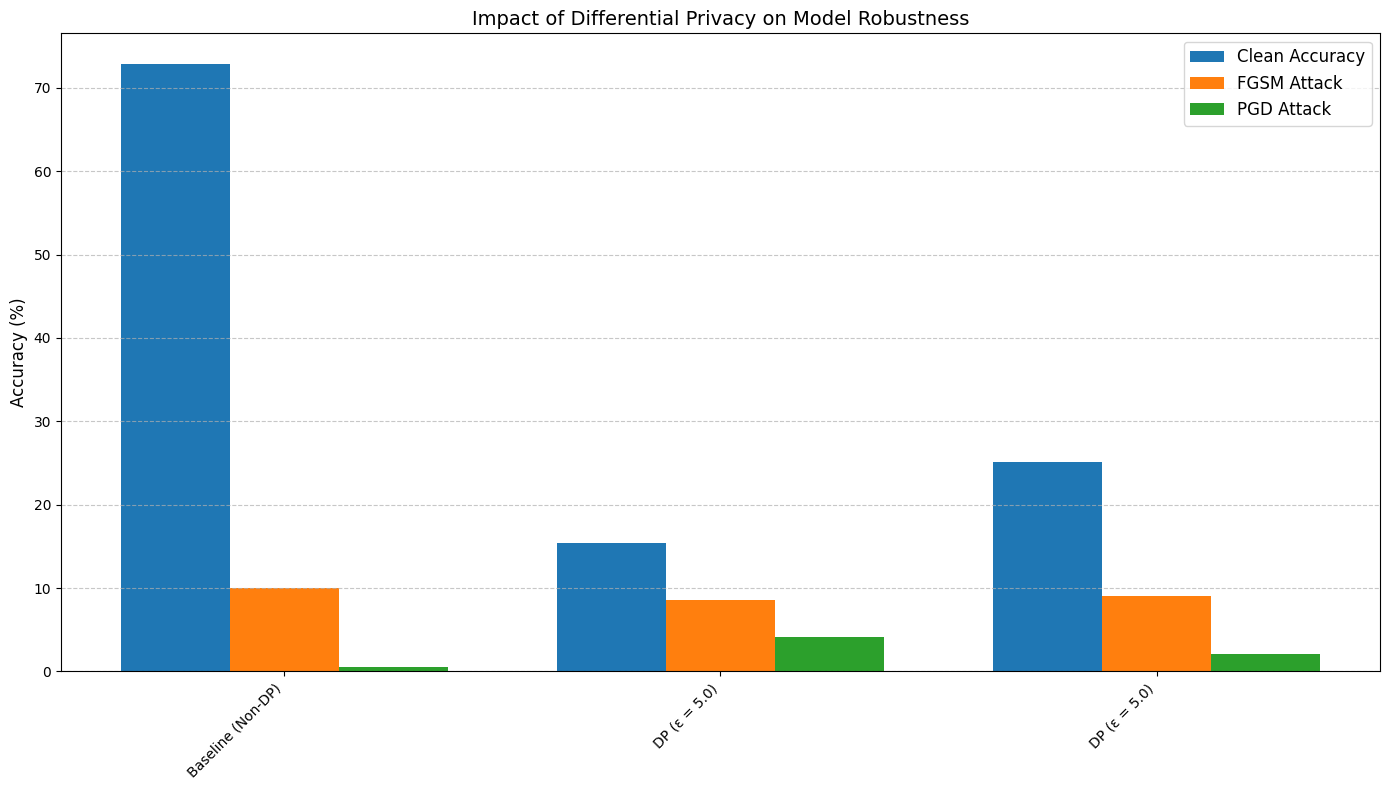

In [3]:
# Define your model class (e.g., QuantumViT)
class ModelClass(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize your model architecture here
        self.quantum_model = QuantumViT(model_name, n_qubits=8, num_classes=10)

    def forward(self, x):
        return self.quantum_model(x)

# Run the privacy budget experiment
privacy_results = privacy_budget_experiment(
    model_class=ModelClass,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    noise_multipliers=[0.1, 10.0],
    epsilon=3,
    epochs=5
)



Training Quantum Model...


Epoch 1/10: 100%|██████████| 32/32 [00:05<00:00,  6.01it/s]


Epoch 1, Loss: 2.1687, Accuracy: 36.30%


Epoch 2/10: 100%|██████████| 32/32 [00:05<00:00,  6.04it/s]


Epoch 2, Loss: 1.8955, Accuracy: 63.80%


Epoch 3/10: 100%|██████████| 32/32 [00:05<00:00,  6.05it/s]


Epoch 3, Loss: 1.5344, Accuracy: 57.70%


Epoch 4/10: 100%|██████████| 32/32 [00:05<00:00,  6.05it/s]


Epoch 4, Loss: 1.2939, Accuracy: 67.20%


Epoch 5/10: 100%|██████████| 32/32 [00:05<00:00,  6.09it/s]


Epoch 5, Loss: 1.0667, Accuracy: 69.20%


Epoch 6/10: 100%|██████████| 32/32 [00:05<00:00,  6.03it/s]


Epoch 6, Loss: 1.0700, Accuracy: 64.10%


Epoch 7/10: 100%|██████████| 32/32 [00:05<00:00,  6.08it/s]


Epoch 7, Loss: 0.9194, Accuracy: 72.70%


Epoch 8/10: 100%|██████████| 32/32 [00:05<00:00,  6.03it/s]


Epoch 8, Loss: 0.7566, Accuracy: 75.60%


Epoch 9/10: 100%|██████████| 32/32 [00:05<00:00,  6.03it/s]


Epoch 9, Loss: 0.5477, Accuracy: 75.90%


Epoch 10/10: 100%|██████████| 32/32 [00:05<00:00,  6.06it/s]


Epoch 10, Loss: 0.4960, Accuracy: 79.90%


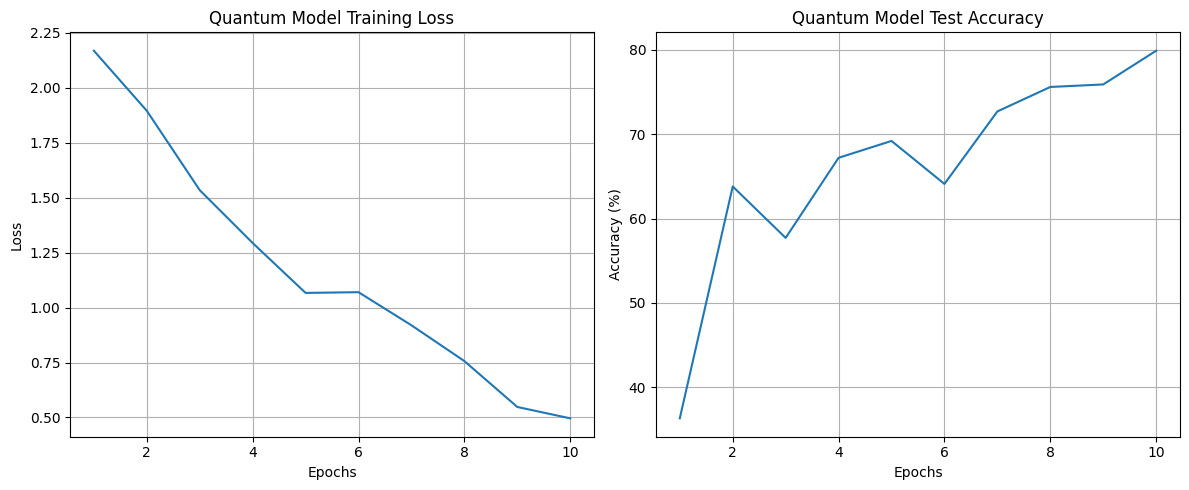


Training Classical Model...


Epoch 1/10: 100%|██████████| 32/32 [00:02<00:00, 11.57it/s]


Epoch 1, Loss: 1.5491, Accuracy: 89.50%


Epoch 2/10: 100%|██████████| 32/32 [00:02<00:00, 11.52it/s]


Epoch 2, Loss: 0.4718, Accuracy: 92.90%


Epoch 3/10: 100%|██████████| 32/32 [00:02<00:00, 11.59it/s]


Epoch 3, Loss: 0.1991, Accuracy: 93.90%


Epoch 4/10: 100%|██████████| 32/32 [00:02<00:00, 11.58it/s]


Epoch 4, Loss: 0.1122, Accuracy: 93.70%


Epoch 5/10: 100%|██████████| 32/32 [00:02<00:00, 11.61it/s]


Epoch 5, Loss: 0.0775, Accuracy: 92.90%


Epoch 6/10: 100%|██████████| 32/32 [00:02<00:00, 11.60it/s]


Epoch 6, Loss: 0.0511, Accuracy: 93.70%


Epoch 7/10: 100%|██████████| 32/32 [00:02<00:00, 11.57it/s]


Epoch 7, Loss: 0.0385, Accuracy: 93.60%


Epoch 8/10: 100%|██████████| 32/32 [00:02<00:00, 11.56it/s]


Epoch 8, Loss: 0.0299, Accuracy: 93.40%


Epoch 9/10: 100%|██████████| 32/32 [00:02<00:00, 11.56it/s]


Epoch 9, Loss: 0.0233, Accuracy: 93.80%


Epoch 10/10: 100%|██████████| 32/32 [00:02<00:00, 11.56it/s]


Epoch 10, Loss: 0.0204, Accuracy: 93.50%


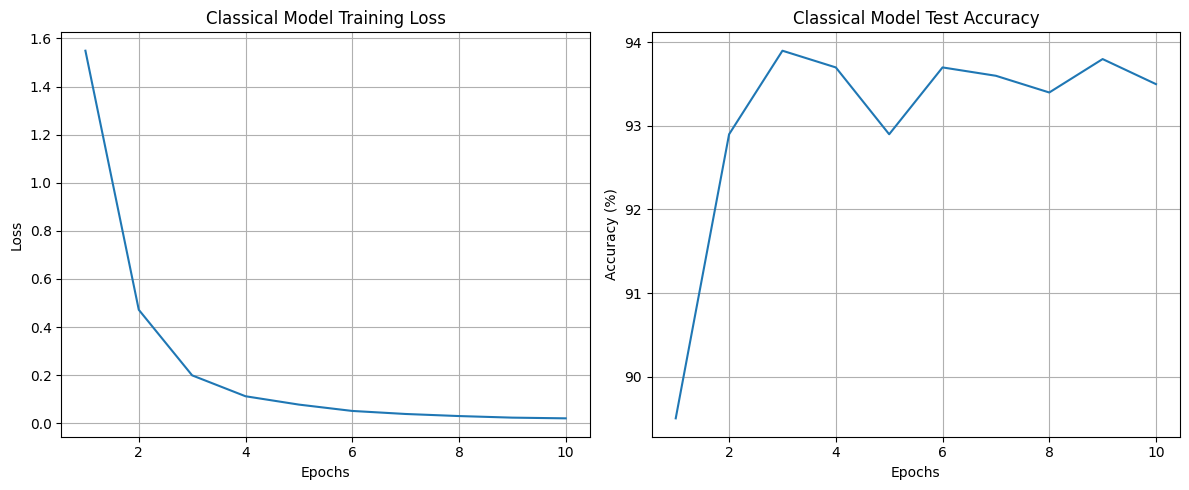


Final Accuracy - Quantum Model: 79.90%, Classical Model: 93.50%

Evaluating Quantum model
Quantum Clean Accuracy: 79.90%


Testing ε=3e-05: 100%|██████████| 32/32 [01:15<00:00,  2.37s/it]


Quantum FGSM (ε=3e-05) Accuracy: 38.60%
Quantum PGD (ε=3e-05) Accuracy: 36.70%


Testing ε=0.003: 100%|██████████| 32/32 [01:16<00:00,  2.40s/it]


Quantum FGSM (ε=0.003) Accuracy: 34.40%
Quantum PGD (ε=0.003) Accuracy: 0.60%


Testing ε=0.3: 100%|██████████| 32/32 [01:16<00:00,  2.39s/it]

Quantum FGSM (ε=0.3) Accuracy: 11.10%
Quantum PGD (ε=0.3) Accuracy: 5.30%

Evaluating Classical model


Classical Clean Accuracy: 93.50%


Testing ε=3e-05: 100%|██████████| 32/32 [00:54<00:00,  1.70s/it]


Classical FGSM (ε=3e-05) Accuracy: 61.50%
Classical PGD (ε=3e-05) Accuracy: 60.20%


Testing ε=0.003: 100%|██████████| 32/32 [00:54<00:00,  1.70s/it]


Classical FGSM (ε=0.003) Accuracy: 57.20%
Classical PGD (ε=0.003) Accuracy: 7.60%


Testing ε=0.3: 100%|██████████| 32/32 [00:54<00:00,  1.70s/it]


Classical FGSM (ε=0.3) Accuracy: 15.50%
Classical PGD (ε=0.3) Accuracy: 0.60%


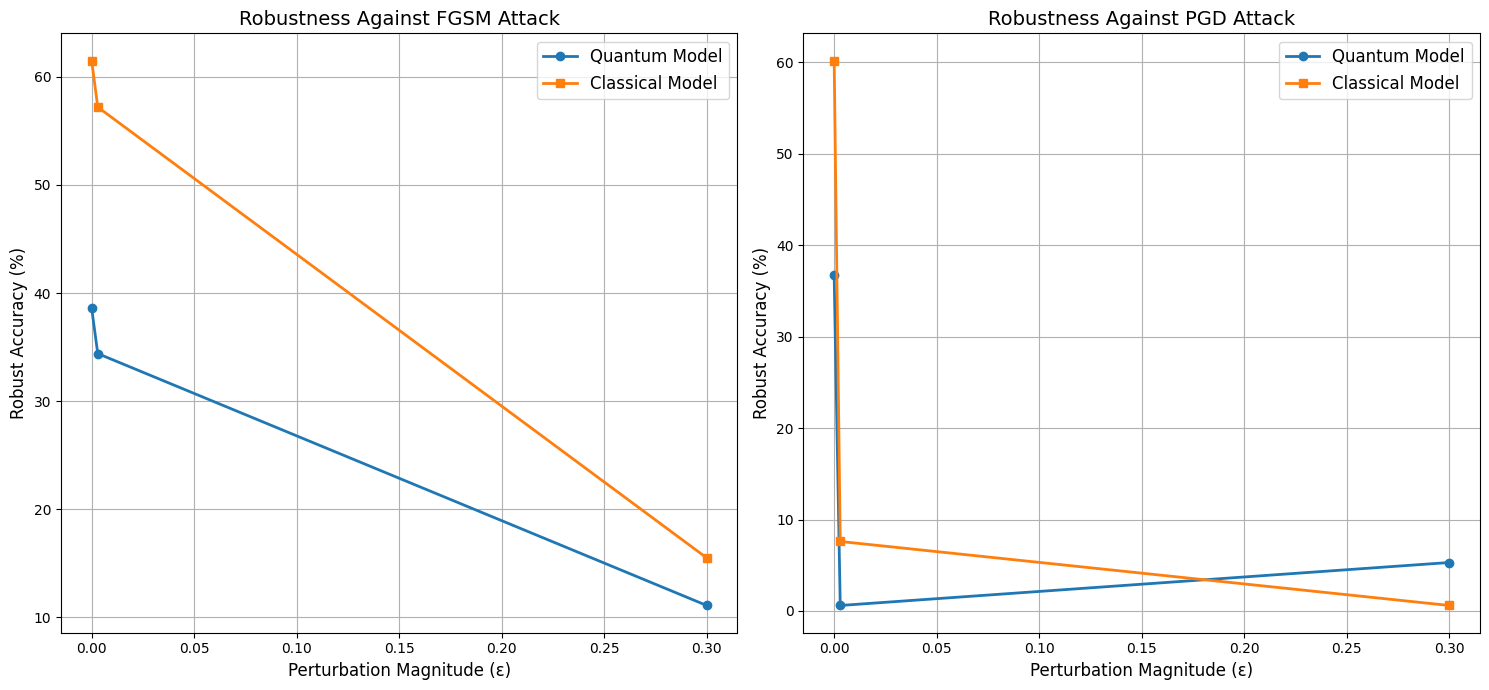

In [5]:
# Initialize your quantum and classical models

# Define a classical equivalent to the QuantumViT model
class ClassicalViT(nn.Module):
    def __init__(self, vit_model_name, hidden_size=8, num_classes=10):
        super().__init__()
        # Load pre-trained ViT model (use the backbone only)
        self.vit = ViTModel.from_pretrained(vit_model_name)

        # Freeze ViT weights for transfer learning
        for param in self.vit.parameters():
            param.requires_grad = False

        # Get ViT hidden size
        vit_hidden_size = self.vit.config.hidden_size  # Typically 768

        # Projection layer to reduce dimensionality
        self.projection = nn.Linear(vit_hidden_size, hidden_size)

        # Classical layers instead of quantum layer
        self.classical_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size*2),
            nn.ReLU(),
            nn.Linear(hidden_size*2, hidden_size),
            nn.Tanh()  # Similar activation as in quantum circuit
        )

        # Classification head
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Extract features using ViT (get [CLS] token)
        outputs = self.vit(x)
        cls_token = outputs.last_hidden_state[:, 0, :]

        # Project to lower dimension
        projected = self.projection(cls_token)

        # Apply classical processing
        classical_output = self.classical_layer(projected)

        # Classification
        logits = self.classifier(classical_output)
        return logits

# Initialize your quantum and classical models
quantum_model = QuantumViT(model_name, n_qubits=8, num_classes=10).to(device)
classical_model = ClassicalViT(model_name, hidden_size=8, num_classes=10).to(device)


# Define training function for both models
def train_model(model, train_loader, test_loader, device, epochs=20, model_name="Model"):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Training metrics
    train_losses = []
    test_accuracies = []

    print(f"\nTraining {model_name}...")

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Handle different output formats (ViT returns logits directly, QuantumViT returns logits)
            if isinstance(outputs, dict) and 'logits' in outputs:
                loss = criterion(outputs.logits, labels)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluation phase
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                if isinstance(outputs, dict) and 'logits' in outputs:
                    _, predicted = torch.max(outputs.logits.data, 1)
                else:
                    _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Plot training progress
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), test_accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} Test Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model, test_accuracies[-1]

# Train the quantum model
# For QuantumViT, we need to train only the quantum layer, projection, and classifier
for param in quantum_model.vit.parameters():
    param.requires_grad = False  # Freeze ViT weights

quantum_model_trained, quantum_acc = train_model(
    quantum_model,
    train_loader,
    test_loader,
    device,
    epochs=20,
    model_name="Quantum Model"
)

# Train the classical model
for param in classical_model.vit.parameters():
    param.requires_grad = False  # Freeze ViT weights

classical_model_trained, classical_acc = train_model(
    classical_model,
    train_loader,
    test_loader,
    device,
    epochs=10,
    model_name="Classical Model"
)

print(f"\nFinal Accuracy - Quantum Model: {quantum_acc:.2f}%, Classical Model: {classical_acc:.2f}%")

# Now run the comparison
comparison_results = quantum_classical_comparison(
    quantum_model=quantum_model_trained,
    classical_model=classical_model_trained,
    test_loader=test_loader,
    device=device,
    epsilons=[0.00003, 0.003, 0.3]
)


Testing adversarial robustness: 100%|██████████| 32/32 [02:19<00:00,  4.36s/it]


Clean Accuracy: 12.50%
FGSM Accuracy: 12.00%
PGD Accuracy: 11.80%


Testing adversarial robustness: 100%|██████████| 32/32 [02:19<00:00,  4.35s/it]


Clean Accuracy: 19.20%
FGSM Accuracy: 16.20%
PGD Accuracy: 16.00%
Epoch 1/10, Loss: 2.2954
Clean Acc: 19.20%, FGSM Acc: 16.20%, PGD Acc: 16.00%


Testing adversarial robustness: 100%|██████████| 32/32 [02:19<00:00,  4.36s/it]


Clean Accuracy: 19.30%
FGSM Accuracy: 16.30%
PGD Accuracy: 16.20%
Epoch 2/10, Loss: 2.2256
Clean Acc: 19.30%, FGSM Acc: 16.30%, PGD Acc: 16.20%


Testing adversarial robustness: 100%|██████████| 32/32 [02:19<00:00,  4.35s/it]


Clean Accuracy: 28.20%
FGSM Accuracy: 20.50%
PGD Accuracy: 20.20%
Epoch 3/10, Loss: 2.1674
Clean Acc: 28.20%, FGSM Acc: 20.50%, PGD Acc: 20.20%


Testing adversarial robustness: 100%|██████████| 32/32 [02:19<00:00,  4.35s/it]


Clean Accuracy: 47.90%
FGSM Accuracy: 30.70%
PGD Accuracy: 30.40%
Epoch 4/10, Loss: 2.0859
Clean Acc: 47.90%, FGSM Acc: 30.70%, PGD Acc: 30.40%


Testing adversarial robustness: 100%|██████████| 32/32 [02:19<00:00,  4.36s/it]


Clean Accuracy: 57.30%
FGSM Accuracy: 39.60%
PGD Accuracy: 39.00%
Epoch 5/10, Loss: 2.0083
Clean Acc: 57.30%, FGSM Acc: 39.60%, PGD Acc: 39.00%


Testing adversarial robustness: 100%|██████████| 32/32 [02:19<00:00,  4.35s/it]


Clean Accuracy: 68.20%
FGSM Accuracy: 46.30%
PGD Accuracy: 45.60%
Epoch 6/10, Loss: 1.9166
Clean Acc: 68.20%, FGSM Acc: 46.30%, PGD Acc: 45.60%


Testing adversarial robustness: 100%|██████████| 32/32 [02:19<00:00,  4.35s/it]


Clean Accuracy: 72.40%
FGSM Accuracy: 50.20%
PGD Accuracy: 49.80%
Epoch 7/10, Loss: 1.7968
Clean Acc: 72.40%, FGSM Acc: 50.20%, PGD Acc: 49.80%


Testing adversarial robustness: 100%|██████████| 32/32 [02:19<00:00,  4.35s/it]


Clean Accuracy: 72.80%
FGSM Accuracy: 51.10%
PGD Accuracy: 50.30%
Epoch 8/10, Loss: 1.6799
Clean Acc: 72.80%, FGSM Acc: 51.10%, PGD Acc: 50.30%


Testing adversarial robustness: 100%|██████████| 32/32 [02:19<00:00,  4.35s/it]


Clean Accuracy: 72.80%
FGSM Accuracy: 51.00%
PGD Accuracy: 50.60%
Epoch 9/10, Loss: 1.5561
Clean Acc: 72.80%, FGSM Acc: 51.00%, PGD Acc: 50.60%


Testing adversarial robustness: 100%|██████████| 32/32 [02:19<00:00,  4.35s/it]


Clean Accuracy: 72.70%
FGSM Accuracy: 50.70%
PGD Accuracy: 49.50%
Epoch 10/10, Loss: 1.4385
Clean Acc: 72.70%, FGSM Acc: 50.70%, PGD Acc: 49.50%


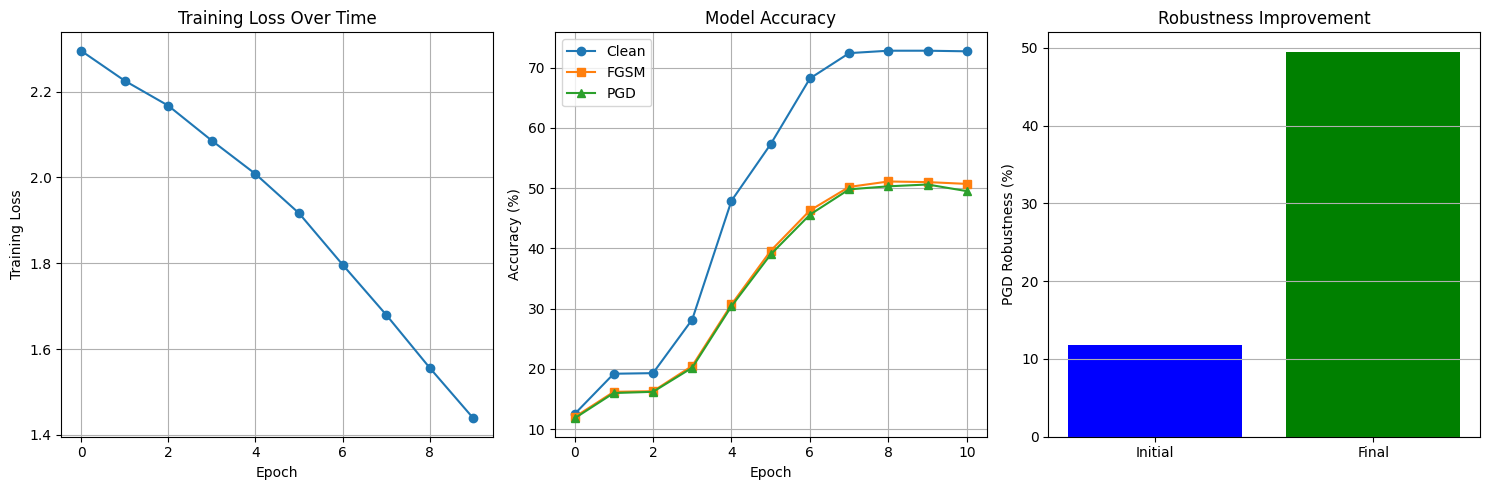

In [6]:
# Initialize a model for adversarial training
model_adv = QuantumViT(model_name, n_qubits=8, num_classes=10).to(device)

# Run mixed adversarial training
trained_model, clean_accs, fgsm_accs, pgd_accs = mixed_adversarial_training(
    model=model_adv,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    epsilon=0.00003,
    alpha=0.01,
    steps=5,
    epochs=10,
    mix_ratio=0.5
)

# NEEDS MORE EPOCHS FOR IT TO PROPERLY LEARNG TRY AT LEAST 10 DUH

/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
Testing adversarial robustness:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Testing adversarial robustness: 100%|██████████| 32/32 [04:19<00:00,  8.11s/it]


Clean Accuracy: 10.30%
FGSM Accuracy: 10.30%
PGD Accuracy: 10.30%


Testing adversarial robustness: 100%|██████████| 32/32 [04:19<00:00,  8.10s/it]
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/prv/prvs.py:67: RuntimeWarning: overflow encountered in exp
  z = np.log(np.where(t > np.log(1 - q), (np.exp(t) + q - 1) / q, 1))
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/prv/prvs.py:67: RuntimeWarning: overflow encountered in divide
  z = np.log(np.where(t > np.log(1 - q), (np.exp(t) + q - 1) / q, 1))


Clean Accuracy: 17.30%
FGSM Accuracy: 12.80%
PGD Accuracy: 12.60%


/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/prv/prvs.py:160: RuntimeWarning: overflow encountered in exp
  d2 = np.flip(np.flip(p * np.exp(-t)).cumsum())
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/prv/prvs.py:160: RuntimeWarning: invalid value encountered in accumulate
  d2 = np.flip(np.flip(p * np.exp(-t)).cumsum())
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/prv/prvs.py:161: RuntimeWarning: overflow encountered in exp
  ndelta = np.exp(t) * d2 - d1
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/prv/prvs.py:161: RuntimeWarning: invalid value encountered in multiply
  ndelta = np.exp(t) * d2 - d1


Epoch 1/10, Loss: 2.2914, Privacy Budget (ε): 353.22
Clean Acc: 17.30%, FGSM Acc: 12.80%, PGD Acc: 12.60%


Testing adversarial robustness: 100%|██████████| 32/32 [04:19<00:00,  8.10s/it]


Clean Accuracy: 33.50%
FGSM Accuracy: 24.80%
PGD Accuracy: 24.60%
Epoch 2/10, Loss: 2.2244, Privacy Budget (ε): 487.23
Clean Acc: 33.50%, FGSM Acc: 24.80%, PGD Acc: 24.60%


Testing adversarial robustness: 100%|██████████| 32/32 [04:18<00:00,  8.08s/it]


Clean Accuracy: 36.90%
FGSM Accuracy: 27.90%
PGD Accuracy: 27.70%
Epoch 3/10, Loss: 2.1825, Privacy Budget (ε): 599.35
Clean Acc: 36.90%, FGSM Acc: 27.90%, PGD Acc: 27.70%


Testing adversarial robustness: 100%|██████████| 32/32 [04:19<00:00,  8.11s/it]


Clean Accuracy: 39.00%
FGSM Accuracy: 29.40%
PGD Accuracy: 29.20%
Epoch 4/10, Loss: 2.1416, Privacy Budget (ε): 700.44
Clean Acc: 39.00%, FGSM Acc: 29.40%, PGD Acc: 29.20%


Testing adversarial robustness: 100%|██████████| 32/32 [04:18<00:00,  8.09s/it]


Clean Accuracy: 42.50%
FGSM Accuracy: 31.50%
PGD Accuracy: 31.00%


/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/prv/prvs.py:167: RuntimeWarning: overflow encountered in scalar divide
  return np.log((d1[i] - delta_target) / d2[i])


Epoch 5/10, Loss: 2.1083, Privacy Budget (ε): inf
Clean Acc: 42.50%, FGSM Acc: 31.50%, PGD Acc: 31.00%


Testing adversarial robustness: 100%|██████████| 32/32 [04:18<00:00,  8.09s/it]


Clean Accuracy: 43.20%
FGSM Accuracy: 33.10%
PGD Accuracy: 32.80%


/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/prv/prvs.py:160: RuntimeWarning: invalid value encountered in multiply
  d2 = np.flip(np.flip(p * np.exp(-t)).cumsum())


Epoch 6/10, Loss: 2.0969, Privacy Budget (ε): inf
Clean Acc: 43.20%, FGSM Acc: 33.10%, PGD Acc: 32.80%


Testing adversarial robustness: 100%|██████████| 32/32 [04:19<00:00,  8.11s/it]


Clean Accuracy: 43.80%
FGSM Accuracy: 33.90%
PGD Accuracy: 33.70%
Epoch 7/10, Loss: 2.0549, Privacy Budget (ε): inf
Clean Acc: 43.80%, FGSM Acc: 33.90%, PGD Acc: 33.70%


Testing adversarial robustness: 100%|██████████| 32/32 [04:19<00:00,  8.10s/it]


Clean Accuracy: 44.30%
FGSM Accuracy: 33.90%
PGD Accuracy: 33.30%
Epoch 8/10, Loss: 2.0404, Privacy Budget (ε): inf
Clean Acc: 44.30%, FGSM Acc: 33.90%, PGD Acc: 33.30%


Testing adversarial robustness: 100%|██████████| 32/32 [04:18<00:00,  8.09s/it]


Clean Accuracy: 45.40%
FGSM Accuracy: 35.10%
PGD Accuracy: 34.50%
Epoch 9/10, Loss: 1.9976, Privacy Budget (ε): inf
Clean Acc: 45.40%, FGSM Acc: 35.10%, PGD Acc: 34.50%


Testing adversarial robustness: 100%|██████████| 32/32 [04:19<00:00,  8.12s/it]


Clean Accuracy: 49.80%
FGSM Accuracy: 36.80%
PGD Accuracy: 36.30%
Epoch 10/10, Loss: 1.9874, Privacy Budget (ε): inf
Clean Acc: 49.80%, FGSM Acc: 36.80%, PGD Acc: 36.30%
Final Privacy Budget (ε): inf


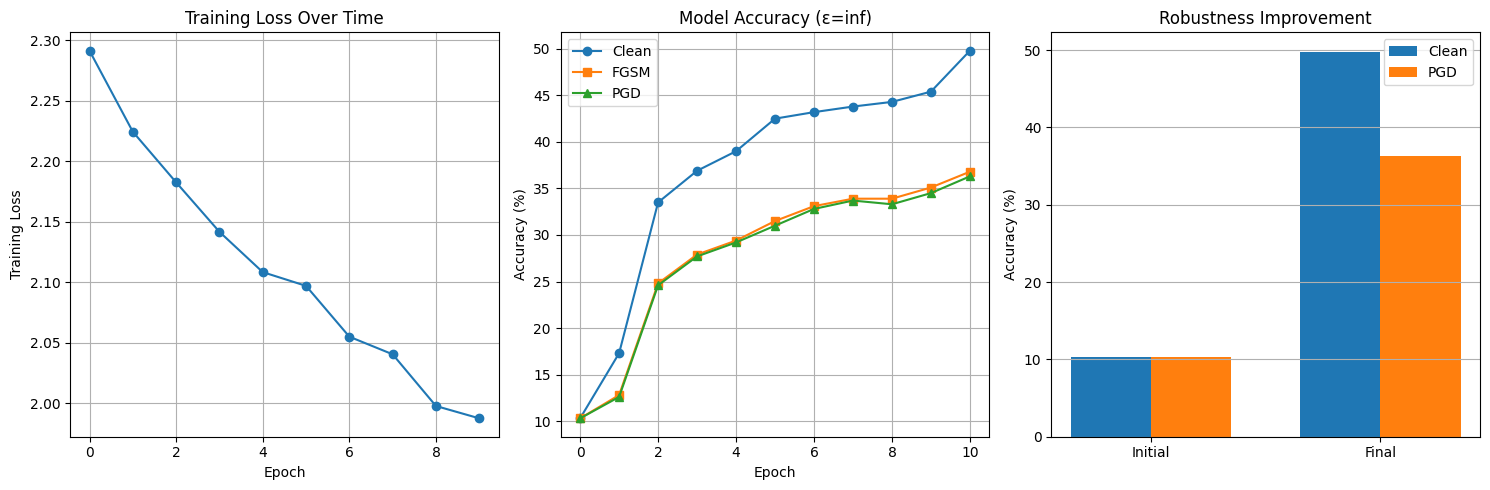

In [4]:
# Initialize a model for DP adversarial training
model_dp_adv = QuantumViT(model_name, n_qubits=8, num_classes=10).to(device)

# Run DP adversarial training
trained_model, final_epsilon, clean_accs, fgsm_accs, pgd_accs = dp_adversarial_training(
    model=model_dp_adv,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    noise_multiplier=0.1,
    max_grad_norm=2.0,
    epsilon=0.00003,
    alpha=0.01,
    steps=5,
    epochs=10,
    mix_ratio=0.5
)


## Comparative Analysis - Extras


Evaluating Quantum-ViT model

Evaluating Classical-ViT model


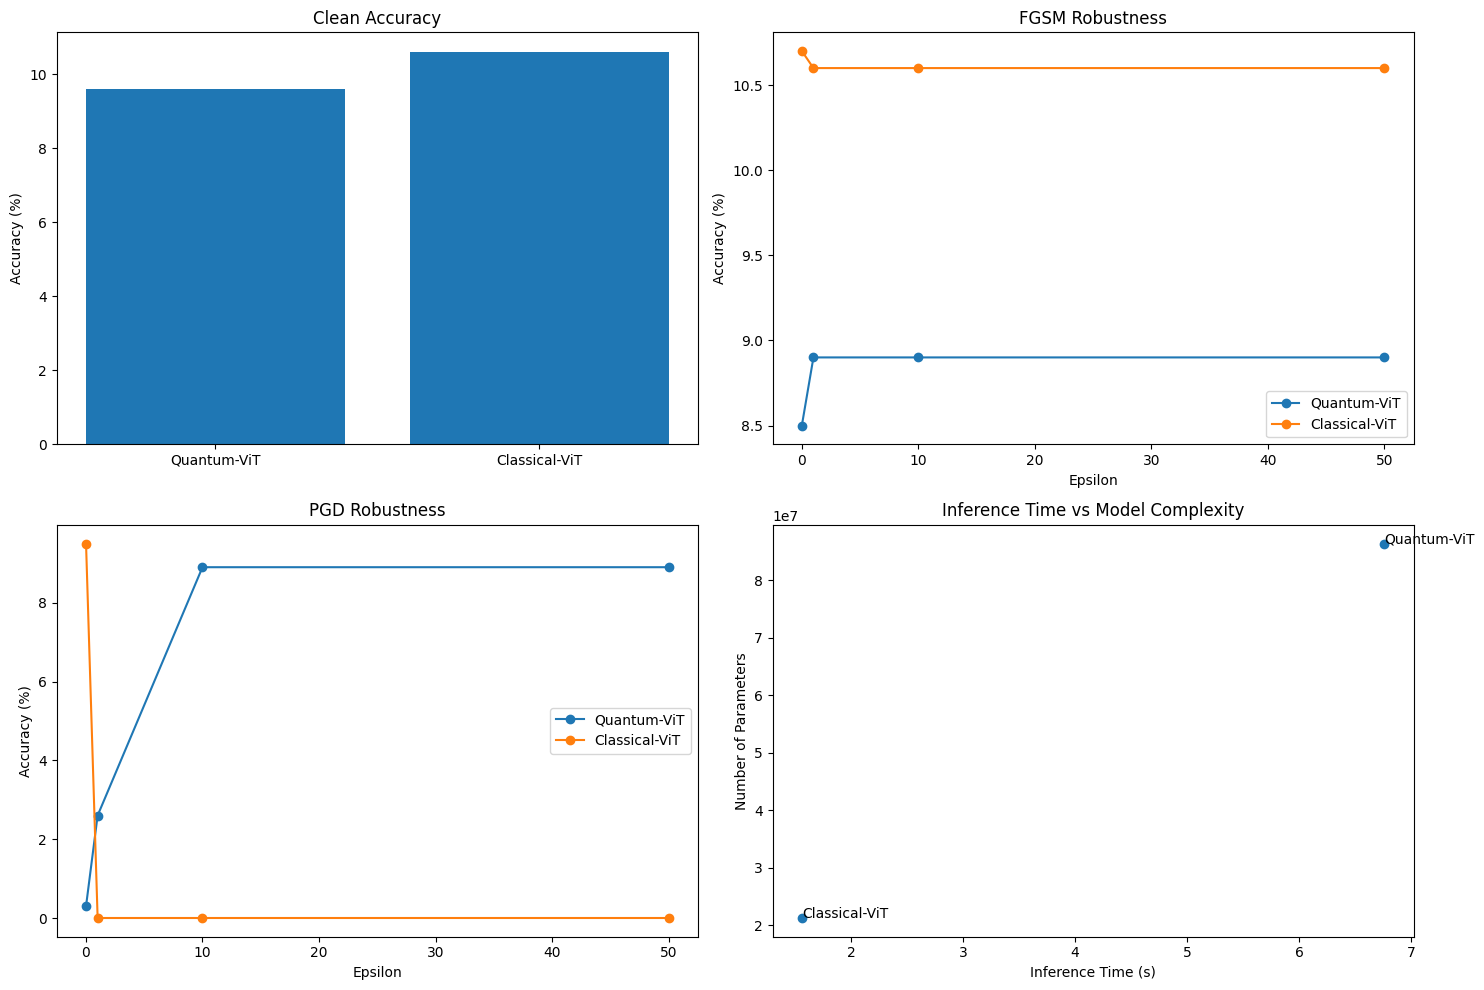

In [6]:
import torchvision.models as models
import time

# Define the classical ResNet model
model_classical = models.resnet34(pretrained=False, num_classes=10)
model_classical = model_classical.to(device)



def expanded_comparative_analysis(models, test_loader, device, epsilons=[0.005, 1.0, 10.0, 50.0]):
    results = {}
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name} model")

        # Clean accuracy
        clean_acc = evaluate_clean_accuracy(model, test_loader, device)

        # Adversarial accuracies
        fgsm_accs = []
        pgd_accs = []
        for eps in epsilons:
            fgsm_acc, pgd_acc = evaluate_adversarial_accuracy(model, test_loader, device, eps)
            fgsm_accs.append(fgsm_acc)
            pgd_accs.append(pgd_acc)

        # Computational efficiency
        inference_time = measure_inference_time(model, test_loader, device)

        # Model complexity
        num_params = sum(p.numel() for p in model.parameters())

        results[model_name] = {
            'clean_accuracy': clean_acc,
            'fgsm_accuracies': fgsm_accs,
            'pgd_accuracies': pgd_accs,
            'inference_time': inference_time,
            'num_parameters': num_params
        }

    visualize_results(results, epsilons)
    return results

def evaluate_clean_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def evaluate_adversarial_accuracy(model, test_loader, device, epsilon):
    fgsm_attack = torchattacks.FGSM(model, eps=epsilon)
    pgd_attack = torchattacks.PGD(model, eps=epsilon, alpha=epsilon/4, steps=10)

    model.eval()
    fgsm_correct = 0
    pgd_correct = 0
    total = 0

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # FGSM attack
        fgsm_images = fgsm_attack(inputs, labels)
        with torch.no_grad():
            outputs = model(fgsm_images)
        _, predicted = torch.max(outputs.data, 1)
        fgsm_correct += (predicted == labels).sum().item()

        # PGD attack
        pgd_images = pgd_attack(inputs, labels)
        with torch.no_grad():
            outputs = model(pgd_images)
        _, predicted = torch.max(outputs.data, 1)
        pgd_correct += (predicted == labels).sum().item()

        total += labels.size(0)

    fgsm_accuracy = 100 * fgsm_correct / total
    pgd_accuracy = 100 * pgd_correct / total

    return fgsm_accuracy, pgd_accuracy

def measure_inference_time(model, test_loader, device):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            _ = model(inputs)
    end_time = time.time()
    return end_time - start_time

def visualize_results(results, epsilons):
    plt.figure(figsize=(15, 10))

    # Plot clean accuracies
    plt.subplot(2, 2, 1)
    clean_accs = [results[model]['clean_accuracy'] for model in results]
    plt.bar(results.keys(), clean_accs)
    plt.title('Clean Accuracy')
    plt.ylabel('Accuracy (%)')

    # Plot FGSM accuracies
    plt.subplot(2, 2, 2)
    for model in results:
        plt.plot(epsilons, results[model]['fgsm_accuracies'], marker='o', label=model)
    plt.title('FGSM Robustness')
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Plot PGD accuracies
    plt.subplot(2, 2, 3)
    for model in results:
        plt.plot(epsilons, results[model]['pgd_accuracies'], marker='o', label=model)
    plt.title('PGD Robustness')
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Plot inference time and model complexity
    plt.subplot(2, 2, 4)
    inference_times = [results[model]['inference_time'] for model in results]
    num_params = [results[model]['num_parameters'] for model in results]
    plt.scatter(inference_times, num_params)
    for i, model in enumerate(results):
        plt.annotate(model, (inference_times[i], num_params[i]))
    plt.title('Inference Time vs Model Complexity')
    plt.xlabel('Inference Time (s)')
    plt.ylabel('Number of Parameters')

    plt.tight_layout()
    plt.savefig('comparative_analysis_results.png', dpi=300)
    plt.show()

# Usage
models = {
    'Quantum-ViT': model_quantum,
    'Classical-ViT': model_classical
    #,
    #'ResNet50': classical_model_trained
}

results = expanded_comparative_analysis(models, test_loader, device)
